# Hurricane Prediction Model

Ryan Abramowitz, H. Katrina Alcala, SooHoon Choi, Taegeun Ohe, and Connor Owen
<hr>

## Background
Hurricanes are thermally driven, rapidly rotating storm systems characterized by a low-pressure center whose wind speed exceeds 74 miles per hour. In 2005, Hurricane Katrina, a large Category 5 Atlantic hurricane, caused over 1,800 deaths and \\$125 billion in damage. The top 10 costliest hurricanes in the United States occurred in 21st century. According to real estate analytics firm CoreLogic Inc, more than 32 million homes are at risk of hurricane damage on the Atlantic and Gulf Coasts, with a combined value of \\$8.5 trillion.

## Problem
The goal of this project is to accurately predict the hurricane trajectories or track forecasting which will identify the location and the intensity of the hurricane by utilizing diverse data sources to reduce economic damages and save lives. Additionally, the class of each tropical cyclone will be predicted to prevent from unnecessary evacuations or unnecessary resources supply (e.g. a tropical cyclone that never develops into a hurricane). A set of predicted models can lower errors and forecast a few days ahead.

#### Table of Contents:
* [Cleaning the Data](#cleaning-the-data)
* [Mapping Storm Trajectory](#mapping-storm-trajectory)
* [Feature Analysis](#feature-analysis)
    * [Histogram of Features](#histogram-of-features)
    * [Heatmap of Features](#heatmap-of-features)
    * [PCA Analysis](#pca-analysis)
    * [Conclusion](#feature-analysis-conclusion)
* [Classification](#classification)
	* [KNN Classification](#knn-analysis)
	* [SVM Classification](#svm-classification)
	* [Decision Tree Classification](#decision-tree-classification)
	* [Random Forest Classification](#random-forest-classification)
	* [Gaussian Naive Bayes Classification](#gaussian-nb-classification)
	* [Conclusion](#classification-conclusion)

## Cleaning the Data <a class="anchor" id="cleaning-the-data"></a>
The dataset used for this project is the Atlantic Hurricane Database, which includes tropical storm and hurricane observations, and is maintained by the National Hurricane Center (NHC). The database includes entries dating as far back as 1851 and include numerous features including longitude, latitude, and windspeed of the storm at given times. `Pandas` was used to clean the data entries of cyclones with missing feature data. Each storm was then classified as a type of tropical cyclone, extratropical cyclone, subtropical cyclone of subtropical depression, low, or tropical wave.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('atlantic.csv')

###cleaning data###
df = df[df.iloc[:,10] != -999]
df['Latitude'] = df['Latitude'].str.replace('[a-zA-Z]','').astype(float)
df['Longitude'] = df['Longitude'].str.replace('[a-zA-Z]','').astype(float)
df['Longitude'] = -1*df['Longitude'] #since the longtitude is in the west

# strip white space and create status list
df['Name'] = df['Name'].apply(lambda x: x.strip())
df['Status_Str'] = df['Status'].loc[:]
df['Status'] = df['Status'].apply(lambda x: x.strip())
status_list = list(pd.unique(df['Status']))
print(status_list)

status_dict = {'TD': 'Tropical cyclone of tropical depression intensity (< 34 knots)',  
               'TS': 'Tropical cyclone of tropical storm intensity (34-63 knots) ' ,
               'HU': 'Tropical cyclone of hurricane intensity (> 64 knots)',  
               'EX': 'Extratropical cyclone (of any intensity)',  
               'SD': 'Subtropical cyclone of subtropical depression intensity (< 34 knots)',  
               'SS': 'Subtropical cyclone of subtropical storm intensity (> 34 knots)',  
               'LO': 'A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)',  
               'WV': 'Tropical Wave (of any intensity)  DB – Disturbance (of any intensity)' }

# make the status an integer value for classification
for i in range(len(status_list)):
    df['Status'].replace(status_list[i], i, inplace=True)
    
df.head()

['TD', 'TS', 'HU', 'EX', 'WV', 'LO', 'SS', 'SD', 'DB']


,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Status_Str
43104,AL012004,ALEX,20040731,1800,,0,30.3,-78.3,25,1010,...,0,0,0,0,0,0,0,0,0,TD
43105,AL012004,ALEX,20040801,0,,0,31.0,-78.8,25,1009,...,0,0,0,0,0,0,0,0,0,TD
43106,AL012004,ALEX,20040801,600,,0,31.5,-79.0,25,1009,...,0,0,0,0,0,0,0,0,0,TD
43107,AL012004,ALEX,20040801,1200,,0,31.6,-79.1,30,1009,...,0,0,0,0,0,0,0,0,0,TD
43108,AL012004,ALEX,20040801,1800,,1,31.6,-79.2,35,1009,...,0,0,0,0,0,0,0,0,0,TS


The chart shown above shows a sample of the cleaned dataset with each storm's respective status stored under the column `Status_Str`.

## Mapping Storm Trajectory <a class="anchor" id="mapping-storm-trajectory"></a>
In order to visualize the hurricane trajectories with respect to wind speed, pressure, and other variables described above, the first 5 hurricanes and their trajectories are plotted using `Plotly` and `Pandas`.

In [3]:
### Helper variables to visualize hurricane trajectory###
ID = pd.unique(df['ID'])

# get idea of spread of data
print(df['Latitude'].describe())
print('--------')
print(df['Longitude'].describe())

count    5921.000000
mean       26.609053
std        10.639764
min         8.300000
25%        17.900000
50%        25.400000
75%        33.000000
max        69.000000
Name: Latitude, dtype: float64
--------
count    5921.000000
mean      -60.573467
std        21.382350
min      -106.700000
25%       -78.100000
50%       -62.000000
75%       -43.900000
max        -0.000000
Name: Longitude, dtype: float64


In [4]:
df.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW',
       'Status_Str'],
      dtype='object')

In [6]:
# plot the first 5 storms in the dataset
import plotly.express as px
fig = px.scatter_geo(df[df['ID'].isin(ID[0:5])], lat='Latitude', lon='Longitude', 
                     color='Name', hover_name='ID', hover_data=['Date', 'Name', 'Status_Str'])
fig.show()

## Feature Analysis <a class="anchor" id="feature-analysis"></a>
In order to lower the cost of running any trajectory prediction algorithm, it would be wise to determine the importance each feature in the dataset. Removing unnecessary features will save time and computational resources in future iterations.

#### Histogram of Features <a class="anchor" id="histogram-of-features"></a>

In [5]:
feat_columns = ['Status', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']

def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

feat_df = df[feat_columns]
feat_df.isna().sum()
numeric_map = feat_df.applymap(is_real_and_finite)
for feat in feat_columns: 
    if (numeric_map[feat]==False).sum():
        print(f'Missing Value found in column: {feat}')

Below is a histogram showing the frequency of each feature in the dataset.

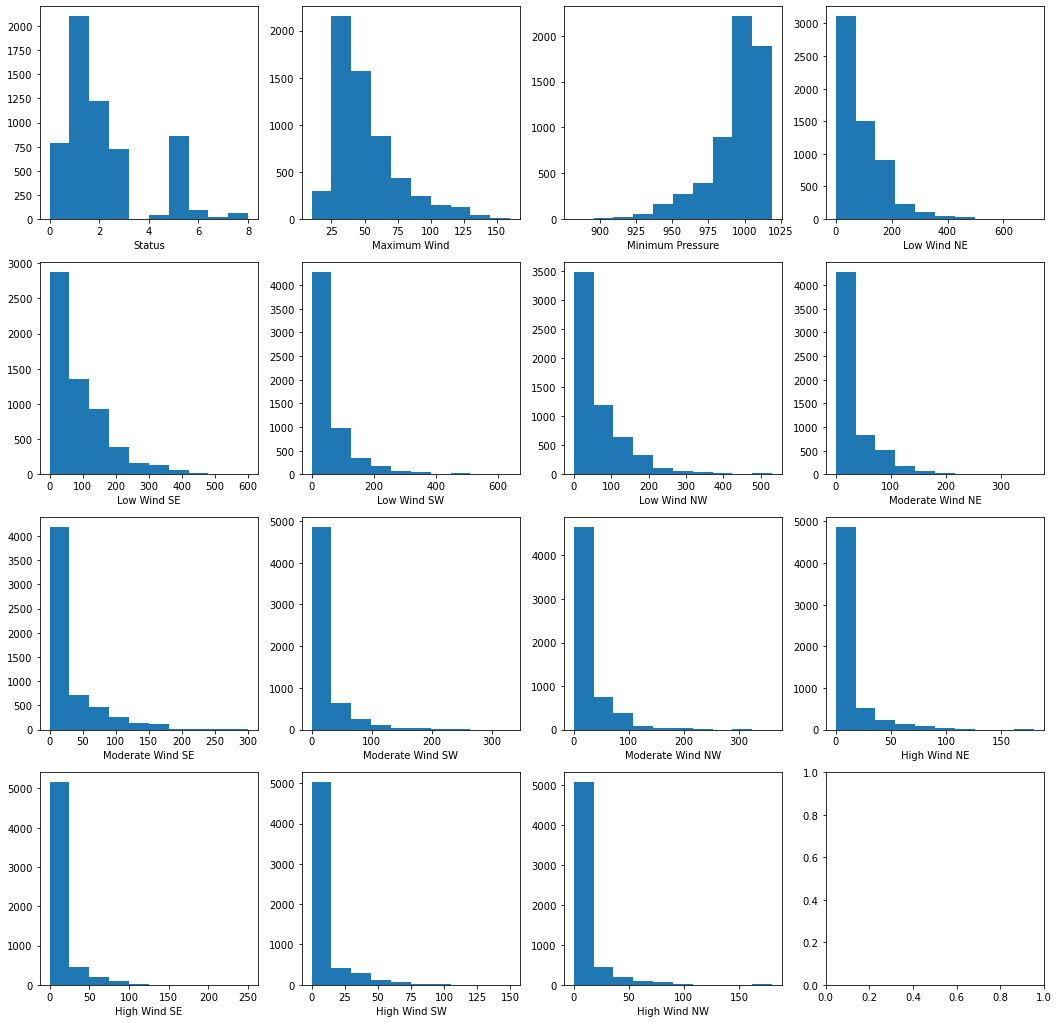

In [6]:
#visualizing the features
N = len(feat_columns)
n = int(np.sqrt(N))
fig, axes = plt.subplots(n+1, n+1, figsize=(6*n, 6*n))
ax = axes.ravel()
for i in range(N):
    ax[i].hist(df[feat_columns[i]])
    ax[i].set_xlabel(feat_columns[i])

#### Heatmap of Features <a class="anchor" id="heatmap-of-features"></a>
In order to visualize the correlation between features, a Pearson heatmap was generated in which the correlation values range from -1 (max negative correlation) to 1 (max positive correlation). Based on the heat map shown, we can make a few assumptions:
* Minimum Pressure is negatively correlated with many of the other features.  
* High winds and low winds have low correlation.
* Moderate/High winds are strongly correlated.

In [7]:
# create heatmap of pearson correlation of features
corr = df[feat_columns].corr(method='pearson')
fig = px.imshow(corr,
                x=feat_columns,
                y=feat_columns,
                color_continuous_scale='RdBu_r'
               )
fig.show()

#### PCA Analysis <a class="anchor" id="pca-analysis"></a>
PCA is used to reduce the number of dimensions in a dataset while retaining the most information by breaking the dataset down into its principal components. The `sklearn` and `seaborn` packages were used in this section to perform the analysis.

[0.65494979 0.10970193 0.04386336 0.03875538 0.03538911 0.02778715
 0.02418346 0.01583164 0.01361641 0.01101179]


<AxesSubplot:xlabel='PC', ylabel='Var'>

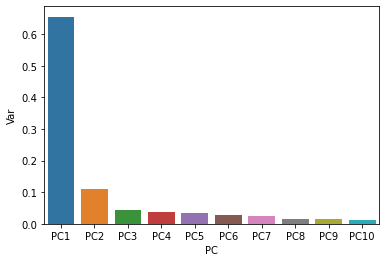

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

Xs = StandardScaler().fit_transform(df[feat_columns[1:]])  # we exclude 'Status' from feat_columns
pca = PCA(n_components=10)
pc_df = pca.fit_transform(Xs)

print(pca.explained_variance_ratio_)
pca_df = pd.DataFrame({'Var':pca.explained_variance_ratio_, 'PC':['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']})

sns.barplot(x='PC', y='Var', data=pca_df)

The chart above shows that PC1 explains more than 60% of the variance in the data. However, we will want a model that will take more variance into account. Next, we will determine how many principal components are necessary to capture at least 90% of the data's variance. 

In [9]:
#number of components to capture 90% of variance
pca = PCA(0.9)
pca.fit(Xs)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

print('number of PCs to keep:',pca.n_components_)

number of PCs to keep: 6


### Feature Analysis Conclusion <a class="anchor" id="feature-analysis-conclusion"></a>
Based on the feature analysis done above, it has been shown that for the dataset examined a total of 6 principal components are necessary to maintain 90% of the dataset's variance. This is a 40% reduction from the original number of components. 

## Classification <a class="anchor" id="classification"></a>
One of the goals of this project is to choose a classification algorithm which can be used to classify a future hurricane's status. The algorithms that will compared in this section are KNN, PCA, SVM, Decision Tree, Random Forest, and Gaussian Naive Bayes. 

### KNN Classification <a class="anchor" id="knn-analysis"></a>
The K-Nearest Neighbors (KNN) algorithm determines a point's classification by examining the k-closest training samples in the dataset. This section uses `SMOTE()` which is a technique to help with class balancing when classes have low sample counts by existing samples in the dataset to create synthetic samples. By balancing the classes, we can improve the metrics (precision and recall) on the minority classes.

#### KNN using SMOTE-Balanced Data

In [10]:
### classifying the Status with K-nearest neighbor on SMOTE-balanced data, no PCA ###
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
import time
np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(df[feat_columns], df['Status'], test_size=0.3)

y_train = y_train.astype(int) #need to convert to int for SMOTE 

# oversample with SMOTE technique
oversample = SMOTE() 
X_train, y_train = oversample.fit_resample(X_train, y_train)
 
knnscore = 0
time_start = time.time()

for i in range(3,20):
    knn = KNeighborsClassifier(n_neighbors = i)

    knn.fit(X_train, y_train)
    knn_score = knn.score(X_test, y_test)
    y_pred = knn.predict(X_test)
    if knn_score > knnscore:
        knnscore = knn_score
        a = i

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred, digits=3))
print("Optimal K:{}".format(a))
print("KNN score:{}".format(knnscore))
print("KNN time elapsed:{}".format(time.time()-time_start))

Optimal K:4
KNN score:0.9099606077658976
KNN time elapsed:6.834737062454224


Counter({1: 2100, 2: 1226, 5: 863, 0: 788, 3: 721, 6: 95, 8: 62, 4: 46, 7: 20})


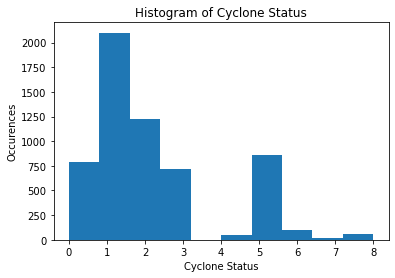

In [11]:
# investigate class imbalances in the cyclone status feature 
from collections import Counter
counter = Counter(df['Status'])
print(counter)
plt.hist(df['Status'])
plt.title('Histogram of Cyclone Status')
plt.xlabel('Cyclone Status')
plt.ylabel('Occurences')
plt.show()

Counter({0: 2100, 1: 2100, 2: 2100, 3: 2100, 4: 2100, 5: 2100, 6: 2100, 7: 2100, 8: 2100})


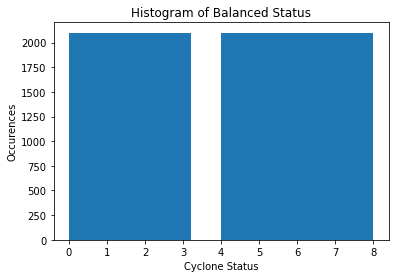

In [12]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

feat_columns = ['Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']

# transform the dataset with SMOTE 
oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(df[feat_columns], df['Status'])

# count samples in new data
counter = Counter(y_balanced)
print(counter)

plt.hist(y_balanced)
plt.title('Histogram of Balanced Status')
plt.xlabel('Cyclone Status')
plt.ylabel('Occurences')
plt.show()


#### KNN using PCA and SMOTE-Imbalanced Data

Principle Component Analysis (PCA) combined with KNN will reduce the dimensionality of the model and results in lower compute times. Since PCA eliminates redundant information, combining it with KNN will result in improved performance.

In [13]:
### classifying the Status with K-nearest neighbor using PCA, imbalanced data###
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import time
np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(df[feat_columns], df['Status'], test_size=0.3)

pca.fit(X_train, y_train)
print(X_train.shape)

scores = {}
time_start = time.time()

# find optimal k
for i in range(2,int(np.sqrt(df.shape[0]))):
    knn_unbalanced = KNeighborsClassifier(n_neighbors = i)
    
    knn_unbalanced.fit(pca.transform(X_train), y_train)
    knn_score = knn_unbalanced.score(pca.transform(X_test), y_test)

    scores[i] = knn_score

# choose best k and train model again
opt_k = max(scores, key=scores.get)
knn_unbalanced = KNeighborsClassifier(n_neighbors = opt_k)
knn_unbalanced.fit(pca.transform(X_train), y_train)
y_pred = knn_unbalanced.predict(pca.transform(X_test))

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred, digits=3, zero_division=0))
print(f"Optimal K:{opt_k}")
print(f"KNN score:{scores[opt_k]}")
print(f"KNN time elapsed:{time.time()-time_start}")

(4144, 14)
Optimal K:16
KNN score:0.7884074282498593
KNN time elapsed:5.4188292026519775


#### KNN using PCA and SMOTE-Balanced Data

In [14]:
### classifying the Status with K-nearest neighbor on SMOTE-balanced data, using PCA  ###
X_train, X_test, y_train, y_test = train_test_split(df[feat_columns], df['Status'], test_size=0.3)
y_train = y_train.astype(int) #need to convert to int for SMOTE 

# oversample with SMOTE technique
oversample = SMOTE() 
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)
 
pca.fit(X_train_balanced, y_train_balanced)

scores = {}
time_start = time.time()

# find optimal k
for i in range(2,int(np.sqrt(df.shape[0]))):
    knn_balanced = KNeighborsClassifier(n_neighbors = i)
    
    knn_balanced.fit(pca.transform(X_train_balanced), y_train_balanced)
    knn_score = knn_balanced.score(pca.transform(X_test), y_test)

    scores[i] = knn_score

# choose best k and train model again
opt_k = max(scores, key=scores.get)
knn_balanced = KNeighborsClassifier(n_neighbors = opt_k)
knn_balanced.fit(pca.transform(X_train_balanced), y_train_balanced)
y_pred = knn_balanced.predict(pca.transform(X_test))

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred, digits=3, zero_division=0))
print(f"Optimal K:{opt_k}")
print(f"KNN score:{scores[opt_k]}")
print(f"KNN time elapsed:{time.time()-time_start}")

Optimal K:3
KNN score:0.6859876195835678
KNN time elapsed:5.957917213439941


#### KNN using PCA Analysis with Random Oversampling Balanced Data

In [15]:
### classifying the Status with K-nearest neighbor on randomly oversampled balanced data, using PCA  ###

# oversample with SMOTE technique
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_oversample, y_train_oversample = oversample.fit_resample(X_train, y_train)
 
pca.fit(X_train_oversample, y_train_oversample)

scores = {}
time_start = time.time()

# find optimal k
for i in range(2,int(np.sqrt(df.shape[0]))):
    knn_balanced = KNeighborsClassifier(n_neighbors = i)
    
    knn_balanced.fit(pca.transform(X_train_oversample), y_train_oversample)
    knn_score = knn_balanced.score(pca.transform(X_test), y_test)

    scores[i] = knn_score

# choose best k and train model again
opt_k = max(scores, key=scores.get)
knn_balanced = KNeighborsClassifier(n_neighbors = opt_k)
knn_balanced.fit(pca.transform(X_train_oversample), y_train_oversample)
y_pred = knn_balanced.predict(pca.transform(X_test))

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred, digits=3, zero_division=0))
print(f"Optimal K:{opt_k}")
print(f"KNN Accuracy:{scores[opt_k]}")
print(f"KNN time elapsed:{time.time()-time_start}")

Optimal K:6
KNN Accuracy:0.7231288688801351
KNN time elapsed:5.431770086288452


The chart below shows the results for the previous 4 techniques. When comparing the previous KNN/PCA methods it is apparent that KNN using SMOTE-Balanced Data produces the largest KNN Score. However, including PCA will help prevent oversampling and reduce runtime. For larger datasets and more complex algorithms, it will be benificial for to use PCA. For the next classification techniques, we will be incorporating PCA.

| Method                                               | Optimal K | KNN Score | Time (s)|
| ---------------------------------------------------- | --------- | --------- | ------- |
| KNN using SMOTE-Balanced Data                        | 4         | 0.90996   | 6.83    |
| KNN using PCA and SMOTE-Imbalanced Data              | 16        | 0.78840   | 5.42    |
| KNN using PCA and SMOTE-Balanced Data                | 3         | 0.68599   | 5.96    |
| KNN using PCA and Random Oversampling Balanced Data  | 6         | 0.72312   | 5.43    |

### SVM Classification <a class="anchor" id="svm-classification"></a>
Support Vector Machines (SVMs) can be used for data classification. Below we attempt to classify the status of a hurrican using the `sklearn` libraries.

In [16]:
### classifying the Status with Support Vector Machine on class unbalanced data###
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

time_start = time.time()

sigmas = np.array([1e-3, 1e-2, 1e-1, 1, 10, 100])
gammas = 1. / 2 / sigmas**2

alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
Cs = 1 / alphas

parameter_ranges = {'C': Cs, 'gamma': gammas}

svc = SVC(kernel = 'rbf')

svc_search = GridSearchCV(svc, parameter_ranges, cv = 3)
svc_search.fit(pca.transform(X_train), y_train)
print("SVM time elapsed:{}".format(time.time()-time_start))
print("Optimum hyperparameters:{}".format(svc_search.best_estimator_))

SVM time elapsed:1897.75146818161
Optimum hyperparameters:SVC(C=100.0, gamma=5e-05)


In [17]:
best_svc = svc_search.best_estimator_
print("SVM score:{}".format(best_svc.score(pca.transform(X_test), y_test)))

SVM score:0.799099606077659


### Decision Tree Classification <a class="anchor" id="decision-tree-classification"></a>
A decision tree is non-parametric supervised learning method used for classification which we will use for classifying hurricane status. The tree's goal is to create a model that predicts the status by learning simple decision rules created from the feature data.

#### Decision Tree using Unbalanced Data

In [18]:
### classifying the unbalanced data Status with Decision tree ###
from sklearn.tree import DecisionTreeClassifier

time_start = time.time()

tree = DecisionTreeClassifier()
tree.fit(pca.transform(X_train), y_train)
y_pred = tree.predict(pca.transform(X_test))

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred, digits=3, zero_division=0))
print("Decision Tree score:{}".format(tree.score(pca.transform(X_test), y_test)))
print("Decision Tree time elapsed:{}".format(time.time()-time_start))

Decision Tree score:0.7867191896454699
Decision Tree time elapsed:0.025235891342163086


#### Decision Tree using SMOTE Balanced Data

In [19]:
## Decision tree on SMOTE balanced data ##
time_start = time.time()

tree = DecisionTreeClassifier()
tree.fit(pca.transform(X_train_balanced), y_train_balanced)
y_pred = tree.predict(pca.transform(X_test))

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred, digits=3, zero_division=0))
print("Decision Tree Accuracy:{}".format(tree.score(pca.transform(X_test), y_test)))
print("Decision Tree time elapsed:{}".format(time.time()-time_start))

Decision Tree Accuracy:0.6432189082723692
Decision Tree time elapsed:0.0546259880065918


#### Decision Tree using Randomly Oversampled Balanced Data

In [20]:
## Decision tree on randomly oversampled balanced data ##
time_start = time.time()

tree = DecisionTreeClassifier()
tree.fit(pca.transform(X_train_oversample), y_train_oversample)
y_pred = tree.predict(pca.transform(X_test))

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred, digits=3, zero_division=0))
print("Decision Tree Accuracy:{}".format(tree.score(pca.transform(X_test), y_test)))
print("Decision Tree time elapsed:{}".format(time.time()-time_start))

Decision Tree Accuracy:0.7220033764772088
Decision Tree time elapsed:0.030369997024536133


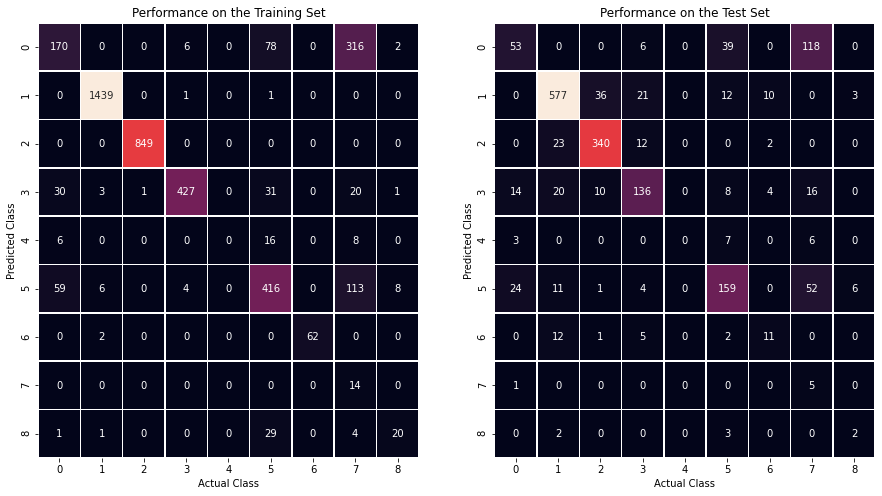

In [21]:
### visualizing the performace of decision tree ###
y_trainpredict = tree.predict(pca.transform(X_train))
heatmap_train = confusion_matrix(y_train, y_trainpredict)

y_testpredict = tree.predict(pca.transform(X_test))
heatmap_test = confusion_matrix(y_test, y_testpredict)

fig, axes = plt.subplots(1, 2, figsize = (15, 8))
sns.heatmap(heatmap_train, annot = True, cbar = False, linewidth = .5, ax = axes[0], fmt = 'd')
sns.heatmap(heatmap_test, annot = True, cbar = False, linewidth = .5, ax = axes[1], fmt = 'd')

axes[0].set_xlabel('Actual Class')
axes[0].set_ylabel('Predicted Class')
axes[0].set_title('Performance on the Training Set')

axes[1].set_xlabel('Actual Class')
axes[1].set_ylabel('Predicted Class')
axes[1].set_title('Performance on the Test Set');

| Decision Tree Method                            | Accuracy | Time (s) | 
| ----------------------------------------------- | -------- | ---- |
| Decision Tree using Unbalanced Data             | 0.78672  | 0.025 |
| Decision Tree using SMOTE Balanced Data         | 0.64322  | 0.055 |
| Decision Tree Random Oversampling Balanced Data | 0.72201  | 0.031 |

### Random Forest Classification <a class="anchor" id="random-forest-classification"></a>
Random forest is a classification works by harnessing the power of many decisions trees. It uses bagging and feature randomness when building each individual tree to  create an uncorrelated forest of trees. The predictions generated by random forest should prove to be more accurate than that of a decision tree.

#### Random Forest using Unbalanced Data

In [22]:
## Random forest classifier on unbalanced data##
from sklearn.ensemble import RandomForestClassifier

# define the model
model = RandomForestClassifier(n_estimators=100, criterion='gini')
# fit the model on the whole dataset
model.fit(pca.transform(X_train), y_train)
time_start = time.time()

y_pred = model.predict(pca.transform(X_test))
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred, digits=3, zero_division=0))
print("Random Forest Accuracy:{}".format(model.score(pca.transform(X_test), y_test)))
print("Random Forest time elapsed:{}".format(time.time()-time_start))

Random Forest Accuracy:0.8142937535171637
Random Forest time elapsed:0.07312989234924316


#### Random Forest using SMOTE Balanced Data

In [23]:
## Random forest classifier on SMOTE balanced data##
from sklearn.ensemble import RandomForestClassifier

# define the model
model = RandomForestClassifier(n_estimators=100, criterion='gini')
# fit the model on the whole dataset
model.fit(pca.transform(X_train_balanced), y_train_balanced)
time_start = time.time()

y_pred = model.predict(pca.transform(X_test))
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred, digits=3, zero_division=0))

print("Random Forest Accuracy:{}".format(model.score(pca.transform(X_test), y_test)))
print("Random Forest time elapsed:{}".format(time.time()-time_start))

Random Forest Accuracy:0.6657287563308948
Random Forest time elapsed:0.07375693321228027


#### Random Forest using Randomly Oversampled Balanced Data

In [25]:
## Random forest classifier on randomly oversampled balanced data##
from sklearn.ensemble import RandomForestClassifier

# define the model
model = RandomForestClassifier(n_estimators=100)
# fit the model on the whole dataset
model.fit(pca.transform(X_train_oversample), y_train_oversample)
time_start = time.time()

y_pred = model.predict(pca.transform(X_test))
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred, digits=3, zero_division=0))
print("Random Forest Accuracy:{}".format(model.score(pca.transform(X_test), y_test)))
print("Random Forest time elapsed:{}".format(time.time()-time_start))

Random Forest Accuracy:0.7467642093415869
Random Forest time elapsed:0.07134509086608887


In [27]:
# can achieve higher accuracy when taking into account lat/lon
test_cols = ['Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']

xtr, xt, ytr, yt = train_test_split(df[test_cols], df['Status'], test_size=0.3)

model = RandomForestClassifier(n_estimators=100, criterion='gini')
# fit the model on the whole dataset
model.fit(xtr, ytr)
time_start = time.time()

y_pred = model.predict(xt)
#print(confusion_matrix(yt, y_pred))
#print(classification_report(yt, y_pred, digits=3, zero_division=0))
print("Random Forest Accuracy:{}".format(model.score(xt, yt)))
print("Random Forest time elapsed:{}".format(time.time()-time_start))

Random Forest Accuracy:0.9026449071468767
Random Forest time elapsed:0.06871294975280762


| Random Forest Method                                          | Accuracy | Time | 
| ----------------------------------------------- | -------- | ---- |
| Random Forest using Unbalanced Data             | 0.81429 | 0.073 |
| Random Forest using SMOTE Balanced Data         | 0.66573 | 0.074 |
| Random Forest Random Oversampling Balanced Data | 0.74001 | 0.070 |

### Gaussian Naive Bayes Classification <a class="anchor" id="gaussian-nb-classification"></a>
Gaussian Naive Bayes classification uses supervised learning algorithms to applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. Below is an implementation of this classification technique using `sklearn`.

In [26]:
### classifying the Status with Guassian Naive Bayes ###

from sklearn.naive_bayes import GaussianNB

time_start = time.time()

NB = GaussianNB()
NB.fit(pca.transform(X_train), y_train)
NB_score = NB.score(pca.transform(X_test), y_test)

print("Gaussian NB Accuracy:{}".format(NB_score))
print("Gaussian NB time elapsed:{}".format(time.time()-time_start))

Gaussian NB Accuracy:0.6010129431626337
Gaussian NB time elapsed:0.009894132614135742


### Classification Conclusion <a class="anchor" id="classification-conclusion"></a>

| Method                                               | Accuracy|  Time   | 
| ---------------------------------------------------- | ------- | ------- |
| KNN using SMOTE-Balanced Data                        | 0.90996 | 6.83    |
| KNN using PCA and SMOTE-Imbalanced Data              | 0.78840 | 5.42    |
| KNN using PCA and SMOTE-Balanced Data                | 0.68599 | 5.96    |
| KNN using PCA and Random Oversampling Balanced Data  | 0.72312 | 5.43    |
| SVM using Unbalance Data                             | 0.79910 | 1897.75 |
| Decision Tree using Unbalanced Data                  | 0.78672 | 0.025   |
| Decision Tree using SMOTE Balanced Data              | 0.64322 | 0.055   |
| Decision Tree Random Oversampling Balanced Data      | 0.72201 | 0.031   |
| Random Forest using Unbalanced Data                  | 0.81429 | 0.073   |
| Random Forest using SMOTE Balanced Data              | 0.66573 | 0.074   |
| Random Forest Random Oversampling Balanced Data      | 0.74001 | 0.070   |
| Gaussian Naive Bayes                                 | 0.60101 | 0.010   |

When looking at the results of the classification algorithms using unbalanced data, all the classification algorithms resulted in a decent score (close to 80%) except for the Gaussian Naive Bayes method. Training the models on the class balanced data (whether with SMOTE or random oversampling) helps with precision and recall on the minority classes, while the overall weighted precision goes down. Depending on the use case, the user would need to know the limitations of the model. SVM with gridsearch takes a significant amount of time and should not be used for our purposes. The score is only slightly higher on average but not significantly different. The most reasonable method for classification based on the results is Random Forest.